### based on 
- http://localhost:8187/notebooks/tsainbur/Projects/github_repos/cdcp_chronic/notebooks/neural-analysis/spiketrain_analyses/statements/3.0-units-vary-in-categoricality.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
save_figs = True

In [3]:
import os
# set to be lower priority
#os.nice(1)

In [4]:
interpolations = [
        "AE",
        "AF",
        "AG",
        "AH",
        "BE",
        "BF",
        "BG",
        "BH",
        "CE",
        "CF",
        "CG",
        "CH",
        "DE",
        "DF",
        "DG",
        "DH",
    ]

In [5]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed
from datetime import datetime
from joblib import Parallel, delayed
from functools import reduce
from sklearn.decomposition import PCA
from functools import reduce


/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [6]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

In [7]:
import seaborn as sns
from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic
import scipy.stats
from cdcp.spiketrain_analysis.neurometric import (
    get_interp_points_dists_from_similarity_matrix,
)

In [8]:
%matplotlib inline

In [9]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [10]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]
birds_df = pd.DataFrame(birds, columns = ['bird', 'timestamp', 'sorter']).set_index('bird')

In [11]:
identifiers = ['nm_by_interpolation_16_25', 'spike_count']

In [12]:
n_interp_bins = 16

In [13]:
all_unit_statistics_df= []
for bird, timestamp, sorter in tqdm(birds, desc='birds'):
    
    unit_statistics_df_list = []
    for identifier in identifiers:
        unit_statistics_df = pd.read_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / identifier
        / "{}.pickle".format(bird)
    )
        unit_statistics_df_list.append(unit_statistics_df)
        
    print(bird, 'nrows per', [len(i) for i in unit_statistics_df_list])
    
    # combine dfs
    unit_statistics_df = reduce(lambda x, y: pd.merge(x, y, on = 'unit', how='outer'), unit_statistics_df_list)
    unit_statistics_df['bird'] = bird
    
    all_unit_statistics_df.append(unit_statistics_df)
unit_statistics_df = pd.concat(all_unit_statistics_df)

birds:   0%|          | 0/10 [00:00<?, ?it/s]

B1597 nrows per [6750, 6750]
B1188 nrows per [510, 510]
B1595 nrows per [242, 242]
B1276 nrows per [46, 46]
B1426 nrows per [93, 93]
B1432 nrows per [2157, 2157]
B1170 nrows per [1281, 1281]
B1244 nrows per [141, 141]
B1593 nrows per [7714, 7714]
B1248 nrows per [8698, 8698]


In [14]:
# merge with categorical units
categorical_units_df = pd.read_pickle(DATA_DIR / 'categorical_unit_01_23_22.pickle')
noncategorical_units_df= categorical_units_df[categorical_units_df.categorical_unit == False]
categorical_units_df= categorical_units_df[categorical_units_df.categorical_unit == True]
unit_statistics_df_cat = pd.merge(unit_statistics_df, categorical_units_df, on = ['bird', 'unit'])
print(len(unit_statistics_df))
# subset categorical units
unit_statistics_df_non_cat = pd.merge(unit_statistics_df, noncategorical_units_df, on = ['bird', 'unit'])
unit_statistics_df = unit_statistics_df_cat
print(len(unit_statistics_df), len(unit_statistics_df_non_cat))


### merge with unit types
unit_type_df = pd.read_pickle(DATA_DIR / "unit_classes_01_23_22.pickle")
#unit_type_df = unit_type_df[["nuclei","AP","ML","DV","amplitude","template_amplitude","sr","fw","hw","bird","unit"]]
unit_statistics_df_ut = pd.merge(unit_statistics_df, unit_type_df, on = ['bird', 'unit'])
unit_statistics_df = unit_statistics_df_ut
print(len(unit_statistics_df))

27632
6754 5474
6754


### Create a dataframe of unit info per bird

In [15]:
min_playbacks = 1000
bird_stats = {}
for bird, timestamp, sorter in tqdm(birds, desc='birds'):
    spikesorting_folder = (
        DATA_DIR / "spikesorting" / bird / birds_df.loc[bird].timestamp
    )
    recording_summary_df = pd.read_pickle(spikesorting_folder / "recording_df.pickle")

    # get units that are to be merged
    merged_units = pd.read_pickle(spikesorting_folder / "unit_clusters2.pickle")
    merged_units = merged_units.sort_values(by="n_playbacks", ascending=False)
    merged_units = merged_units[
        merged_units.n_playbacks.astype("float") > min_playbacks
    ]
    merged_units = merged_units.set_index("cluster_id")

    bird_stats[bird] = {
        'merged_units': merged_units,
        'spikesorting_folder': spikesorting_folder,
    }

birds:   0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
all_hrs = []
all_trials = []
all_playbacks = []
all_responses = []
all_punish = []
all_reward = []
all_gb = []
for bird, timestamp, sorter in tqdm(birds, desc='birds'):
    spikesorting_folder = (
        DATA_DIR / "spikesorting" / bird / birds_df.loc[bird].timestamp
    )
    recording_summary_df = pd.read_pickle(spikesorting_folder / "recording_df.pickle")
    all_hrs.append(np.nansum(recording_summary_df.n_hours.values))
    all_trials.append(np.nansum(recording_summary_df.n_trials.values))
    all_playbacks.append(np.nansum(recording_summary_df.n_trials.values))
    all_responses.append(np.nansum(recording_summary_df.n_response.values))
    all_punish.append(np.nansum(recording_summary_df.n_punish.values))
    all_reward.append(np.nansum(recording_summary_df.n_reward.values))
    all_gb.append(np.nansum(recording_summary_df.dat_size_gb.values))
    print(bird, np.nansum(recording_summary_df.n_trials.values))

birds:   0%|          | 0/10 [00:00<?, ?it/s]

B1597 44231.0
B1188 50460.0
B1595 6817
B1276 2
B1426 3212
B1432 63297.0
B1170 31485.0
B1244 2689
B1593 108263.0
B1248 81871.0


In [17]:
np.nansum(all_trials)

392327.0

In [18]:
np.nansum(all_playbacks)

392327.0

In [19]:
np.sum(all_hrs)

5252.381485990741

In [20]:
np.sum(all_responses)

355163.0

In [21]:
np.sum(all_reward)

79169.0

In [22]:
np.sum(all_punish)

53346.0

In [23]:
np.sum(all_gb) / 1000

72.33004007269199

### Melt matrix into 1 row per interpolation

In [24]:
interped_columns = [i  for i in unit_statistics_df.columns if i.split('_')[-1]  in interpolations]
interped_columns_unique = np.unique(['_'.join(i.split('_')[:-1]) for i in interped_columns])

In [25]:
stat_dfs = []
for col in tqdm(interped_columns_unique):
    columns_to_subset = [
        "{}_{}".format(col, i)
        for i in interpolations
        if "{}_{}".format(col, i) in unit_statistics_df.columns
    ]
    columns_to_subset += ["bird", "unit"]
    stat_df = unit_statistics_df[columns_to_subset].melt(id_vars=["bird", "unit"])
    stat_df.columns = ["bird", "unit", "interp", col]
    stat_df["interp"] = [i[-2:] for i in stat_df.interp.values]
    stat_dfs.append(stat_df)

  0%|          | 0/34 [00:00<?, ?it/s]

In [26]:
stat_df = reduce(lambda x, y: pd.merge(x, y, on = ['bird', 'unit', 'interp']), stat_dfs)

In [27]:
stat_df = pd.merge(stat_df, unit_statistics_df_cat[
    [
        "bird",
        "unit",
        "n_trials",
        "n_cued_trials",
        "n_incorrect_trials",
        "n_correct_trials",
        "n_reward_trials",
        "n_passive_trials",
        "n_active_trials",
        "n_spikes",
        "categorical_unit",
        "categoricality",
        
    ]
], on = ['bird', 'unit'])

for interped_column in tqdm(interped_columns_unique):
    prop_nan = np.array(
        [
            np.mean(np.isnan(i)) if type(i) == np.ndarray else 1
            for i in tqdm(stat_df[interped_column].values, leave=False, desc=interped_column)
        ]
    )
    stat_df["{}_prop_nan".format(interped_column)] = prop_nan

  0%|          | 0/34 [00:00<?, ?it/s]

ips:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_inflection_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_inflection_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_inflection_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_inflection_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_max_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_max_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_max_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_max_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_min_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_min_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_min_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_min_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_r2_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_r2_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_r2_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_r2_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_range_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_range_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_range_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_range_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_scaled_slope_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_scaled_slope_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_scaled_slope_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_scaled_slope_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_slope_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_slope_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_slope_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

nm_slope_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

rv:   0%|          | 0/108064 [00:00<?, ?it/s]

sm_correlation:   0%|          | 0/108064 [00:00<?, ?it/s]

sm_cosine:   0%|          | 0/108064 [00:00<?, ?it/s]

sm_euclidean:   0%|          | 0/108064 [00:00<?, ?it/s]

sm_manhattan:   0%|          | 0/108064 [00:00<?, ?it/s]

In [28]:
stat_df[:4]

,bird,unit,interp,ips,nm_inflection_correlation,nm_inflection_cosine,nm_inflection_euclidean,nm_inflection_manhattan,nm_max_correlation,nm_max_cosine,nm_max_euclidean,nm_max_manhattan,nm_min_correlation,nm_min_cosine,nm_min_euclidean,nm_min_manhattan,nm_r2_correlation,nm_r2_cosine,nm_r2_euclidean,nm_r2_manhattan,nm_range_correlation,nm_range_cosine,nm_range_euclidean,nm_range_manhattan,nm_scaled_slope_correlation,nm_scaled_slope_cosine,nm_scaled_slope_euclidean,nm_scaled_slope_manhattan,nm_slope_correlation,nm_slope_cosine,nm_slope_euclidean,nm_slope_manhattan,rv,sm_correlation,sm_cosine,sm_euclidean,sm_manhattan,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,categorical_unit,categoricality,ips_prop_nan,nm_inflection_correlation_prop_nan,nm_inflection_cosine_prop_nan,nm_inflection_euclidean_prop_nan,nm_inflection_manhattan_prop_nan,nm_max_correlation_prop_nan,nm_max_cosine_prop_nan,nm_max_euclidean_prop_nan,nm_max_manhattan_prop_nan,nm_min_correlation_prop_nan,nm_min_cosine_prop_nan,nm_min_euclidean_prop_nan,nm_min_manhattan_prop_nan,nm_r2_correlation_prop_nan,nm_r2_cosine_prop_nan,nm_r2_euclidean_prop_nan,nm_r2_manhattan_prop_nan,nm_range_correlation_prop_nan,nm_range_cosine_prop_nan,nm_range_euclidean_prop_nan,nm_range_manhattan_prop_nan,nm_scaled_slope_correlation_prop_nan,nm_scaled_slope_cosine_prop_nan,nm_scaled_slope_euclidean_prop_nan,nm_scaled_slope_manhattan_prop_nan,nm_slope_correlation_prop_nan,nm_slope_cosine_prop_nan,nm_slope_euclidean_prop_nan,nm_slope_manhattan_prop_nan,rv_prop_nan,sm_correlation_prop_nan,sm_cosine_prop_nan,sm_euclidean_prop_nan,sm_manhattan_prop_nan
0,B1597,9474,AE,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",7.529137,7.12514,7.152187,7.132204,0.628102,0.582507,0.509234,0.501483,0.212181,0.314192,0.449464,0.489202,0.597437,0.822434,0.847986,0.800823,0.415921,0.268315,0.05977,0.012281,138.528892,372.696333,1673.068227,8142.778156,57.617025,100.0,100.0,100.0,"[[0.007944877, 0.012419521, 0.016634403, 0.019...","[[1.0, 0.960486, 0.9149142, 0.9587056, 0.95678...","[[1.0, 0.9633575, 0.9301829, 0.9659082, 0.9627...","[[1.0, 0.9145882, 0.90759414, 0.86016595, 0.88...","[[1.0, 0.9858349, 0.9847991, 0.97092766, 0.979...",5612,9,0,0,0,5600,12,2358,True,0.109401,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0
1,B1597,9474,AF,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",7.029179,7.060066,13.0,8.524363,0.490924,0.493951,0.531064,0.501791,0.461844,0.46966,0.480647,0.495942,0.543072,0.552026,0.848617,0.729715,0.02908,0.024292,0.050417,0.005849,3438.7674,4115.76963,56.209475,792.884808,100.0,99.97865,2.833932,4.637577,"[[0.016027803, 0.024336038, 0.031571742, 0.035...","[[1.0, 0.9600967, 0.95765334, 0.9563544, 0.969...","[[1.0, 0.96551675, 0.9567401, 0.96169275, 0.96...","[[1.0, 0.88105357, 0.885755, 0.70282775, 0.911...","[[1.0, 0.9632765, 0.97379357, 0.91801924, 0.98...",5612,9,0,0,0,5600,12,2358,True,0.109401,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0
2,B1597,9474,AG,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",8.204379,8.609525,7.551757,7.541294,0.518823,0.514424,0.515437,0.503097,0.497939,0.498819,0.49274,0.497738,0.362538,0.378482,0.553078,0.333736,0.020884,0.015605,0.022697,0.005359,168.034211,221.892153,4400.962433,18661.666382,3.509229,3.462694,99.890707,100.0,"[[0.025025528, 0.033703506, 0.03998994, 0.0414...","[[1.0, 0.8948454, 0.89415073, 0.5736817, 0.961...","[[1.0, 0.9090164, 0.9004372, 0.6424036, 0.9646...","[[1.0, 0.8216941, 0.7911576, 0.73795325, 0.786...","[[1.0, 0.9635847, 0.95689726, 0.92169976, 0.94...",5612,9,0,0,0,5600,12,2358,True,0.109401,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0
3,B1597,9474,AH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5612,9,0,0,0,5600,12,2358,True,0.109401,1.0,1,1,1,1,1,1,1,1,1,1,

#### unit categoricality from similarity matrix

In [29]:
def z_score(x):
    return (x - np.mean(x)) / np.std(x)

In [30]:
import copy
def get_categoricality(sm, remove_identity=True, norm=True):
    if type(sm) is not np.ndarray:
        return np.nan
    sm = copy.deepcopy(sm)
    cat = int(sm.shape[0]/2)
    
    if norm:
        sm_tril = sm[np.tril_indices(len(sm), k=-1)]
        sm_min = np.nanmin(sm_tril)
        sm_max = np.nanmax(sm_tril)
        sm = (sm-sm_min) / (sm_max - sm_min)
    
    A = sm[:cat, :cat]
    B = sm[cat:, :cat]
    C = sm[cat:, cat:]
    D = sm[:cat, cat:]
    if remove_identity:
        A = A[np.tril_indices(len(A), k=-1)]
        C = C[np.tril_indices(len(C), k=-1)]
    A_mean = np.nanmean(A)
    B_mean = np.nanmean(B)
    C_mean = np.nanmean(C)
    D_mean = np.nanmean(D)
    if np.any(np.isnan([A_mean, B_mean, C_mean, D_mean])):
        return np.nan
    #return np.mean([A_mean,C_mean]) / (np.mean([A_mean,C_mean, B_mean,D_mean]))
    return (np.mean([A_mean,C_mean]) - np.mean([B_mean,D_mean]))

In [31]:
len(stat_df)

108064

In [32]:
metric = "cosine"

In [33]:
interp_categoricality = [
    get_categoricality(row["sm_{}".format(metric)])
    for idx, row in tqdm(stat_df.iterrows(), total=len(stat_df))
]
stat_df["interp_categoricality"] = interp_categoricality

  0%|          | 0/108064 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


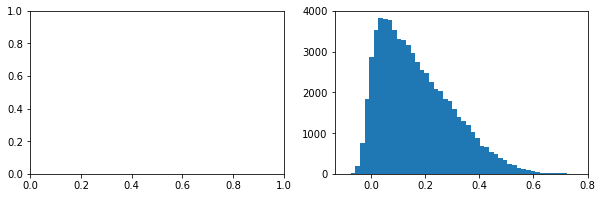

In [34]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3))
axs[1].hist(interp_categoricality, bins = 50);

### Single unit response

In [35]:
unit_statistics_df.sort_values(by='n_cued_trials', ascending=False)[:3]

,sm_correlation_AF,rv_AF,ips_AF,nm_min_correlation_AF,nm_max_correlation_AF,nm_r2_correlation_AF,nm_inflection_correlation_AF,nm_slope_correlation_AF,nm_range_correlation_AF,nm_scaled_slope_correlation_AF,sm_cosine_AF,nm_min_cosine_AF,nm_max_cosine_AF,nm_r2_cosine_AF,nm_inflection_cosine_AF,nm_slope_cosine_AF,nm_range_cosine_AF,nm_scaled_slope_cosine_AF,sm_euclidean_AF,nm_min_euclidean_AF,nm_max_euclidean_AF,nm_r2_euclidean_AF,nm_inflection_euclidean_AF,nm_slope_euclidean_AF,nm_range_euclidean_AF,nm_scaled_slope_euclidean_AF,sm_manhattan_AF,nm_min_manhattan_AF,nm_max_manhattan_AF,nm_r2_manhattan_AF,nm_inflection_manhattan_AF,nm_slope_manhattan_AF,nm_range_manhattan_AF,nm_scaled_slope_manhattan_AF,sm_correlation_AE,rv_AE,ips_AE,nm_min_correlation_AE,nm_max_correlation_AE,nm_r2_correlation_AE,nm_inflection_correlation_AE,nm_slope_correlation_AE,nm_range_correlation_AE,nm_scaled_slope_correlation_AE,sm_cosine_AE,nm_min_cosine_AE,nm_max_cosine_AE,nm_r2_cosine_AE,nm_inflection_cosine_AE,nm_slope_cosine_AE,nm_range_cosine_AE,nm_scaled_slope_cosine_AE,sm_euclidean_AE,nm_min_euclidean_AE,nm_max_euclidean_AE,nm_r2_euclidean_AE,nm_inflection_euclidean_AE,nm_slope_euclidean_AE,nm_range_euclidean_AE,nm_scaled_slope_euclidean_AE,sm_manhattan_AE,nm_min_manhattan_AE,nm_max_manhattan_AE,nm_r2_manhattan_AE,nm_inflection_manhattan_AE,nm_slope_manhattan_AE,nm_range_manhattan_AE,nm_scaled_slope_manhattan_AE,sm_correlation_BF,rv_BF,ips_BF,nm_min_correlation_BF,nm_max_correlation_BF,nm_r2_correlation_BF,nm_inflection_correlation_BF,nm_slope_correlation_BF,nm_range_correlation_BF,nm_scaled_slope_correlation_BF,sm_cosine_BF,nm_min_cosine_BF,nm_max_cosine_BF,nm_r2_cosine_BF,nm_inflection_cosine_BF,nm_slope_cosine_BF,nm_range_cosine_BF,nm_scaled_slope_cosine_BF,sm_euclidean_BF,nm_min_euclidean_BF,nm_max_euclidean_BF,nm_r2_euclidean_BF,nm_inflection_euclidean_BF,nm_slope_euclidean_BF,nm_range_euclidean_BF,nm_scaled_slope_euclidean_BF,sm_manhattan_BF,nm_min_manhattan_BF,nm_max_manhattan_BF,nm_r2_manhattan_BF,nm_inflection_manhattan_BF,nm_slope_manhattan_BF,nm_range_manhattan_BF,nm_scaled_slope_manhattan_BF,sm_correlation_BE,rv_BE,ips_BE,nm_min_correlation_BE,nm_max_correlation_BE,nm_r2_correlation_BE,nm_inflection_correlation_BE,nm_slope_correlation_BE,nm_range_correlation_BE,nm_scaled_slope_correlation_BE,sm_cosine_BE,nm_min_cosine_BE,nm_max_cosine_BE,nm_r2_cosine_BE,nm_inflection_cosine_BE,nm_slope_cosine_BE,nm_range_cosine_BE,nm_scaled_slope_cosine_BE,sm_euclidean_BE,nm_min_euclidean_BE,nm_max_euclidean_BE,nm_r2_euclidean_BE,nm_inflection_euclidean_BE,nm_slope_euclidean_BE,nm_range_euclidean_BE,nm_scaled_slope_euclidean_BE,sm_manhattan_BE,nm_min_manhattan_BE,nm_max_manhattan_BE,nm_r2_manhattan_BE,nm_inflection_manhattan_BE,nm_slope_manhattan_BE,nm_range_manhattan_BE,nm_scaled_slope_manhattan_BE,sm_correlation_CG,rv_CG,ips_CG,nm_min_correlation_CG,nm_max_correlation_CG,nm_r2_correlation_CG,nm_inflection_correlation_CG,nm_slope_correlation_CG,nm_range_correlation_CG,nm_scaled_slope_correlation_CG,sm_cosine_CG,nm_min_cosine_CG,nm_max_cosine_CG,nm_r2_cosine_CG,nm_inflection_cosine_CG,nm_slope_cosine_CG,nm_range_cosine_CG,nm_scaled_slope_cosine_CG,sm_euclidean_CG,nm_min_euclidean_CG,nm_max_euclidean_CG,nm_r2_euclidean_CG,nm_inflection_euclidean_CG,nm_slope_euclidean_CG,nm_range_euclidean_CG,nm_scaled_slope_euclidean_CG,sm_manhattan_CG,nm_min_manhattan_CG,nm_max_manhattan_CG,nm_r2_manhattan_CG,nm_inflection_manhattan_CG,nm_slope_manhattan_CG,nm_range_manhattan_CG,nm_scaled_slope_manhattan_CG,sm_correlation_AG,rv_AG,ips_AG,nm_min_correlation_AG,nm_max_correlation_AG,nm_r2_correlation_AG,nm_inflection_correlation_AG,nm_slope_correlation_AG,nm_range_correlation_AG,nm_scaled_slope_correlation_AG,sm_cosine_AG,nm_min_cosine_AG,nm_max_cosine_AG,nm_r2_cosine_AG,nm_inflection_cosine_AG,nm_slope_cosine_AG,nm_range_cosine_AG,nm_scaled_slope_cosine_AG,sm_euclidean_AG,nm_min_euclidean_AG,nm_max_euclidean_AG,nm_r2_euclidean_AG,nm_inflection_euclidean_AG,nm_slope_euclidea

In [36]:
def zero_one_norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [37]:
from matplotlib.colors import LinearSegmentedColormap
def get_cmap(interp, left_to_right_colors=["#e69138", "#6aa84f"]):
    n_samp = len(interp)

    categorical_gradient_cmap = LinearSegmentedColormap.from_list(
        "left_to_right", left_to_right_colors, N=n_samp
    )
    cmaps = {}
    for gpi, grad_point in enumerate(
        categorical_gradient_cmap(np.linspace(0, 1, n_samp))
    ):
        cmaps[gpi] = LinearSegmentedColormap.from_list(
            "test", [(0.95, 0.95, 0.95, 1), grad_point], N=512
        )
    mapped = np.stack([cmaps[i](j) for i, j in enumerate(zero_one_norm(interp))])
    return mapped

3428


  0%|          | 0/16 [00:00<?, ?it/s]

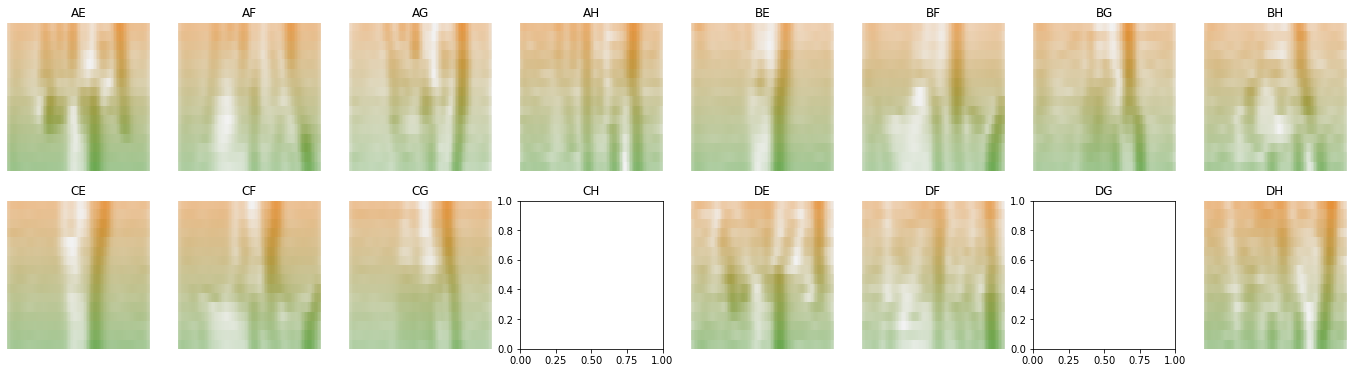

11670


  0%|          | 0/16 [00:00<?, ?it/s]

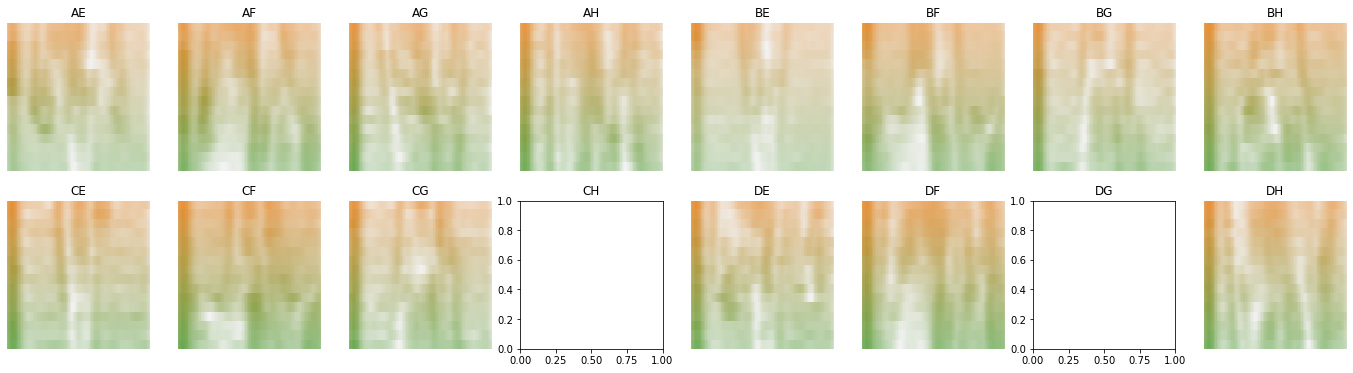

8542


  0%|          | 0/16 [00:00<?, ?it/s]

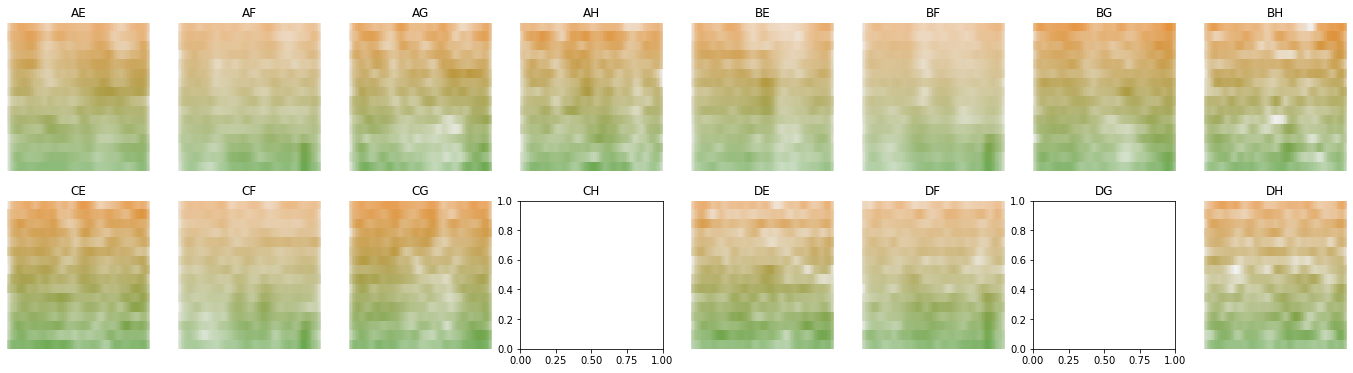

4957


  0%|          | 0/16 [00:00<?, ?it/s]

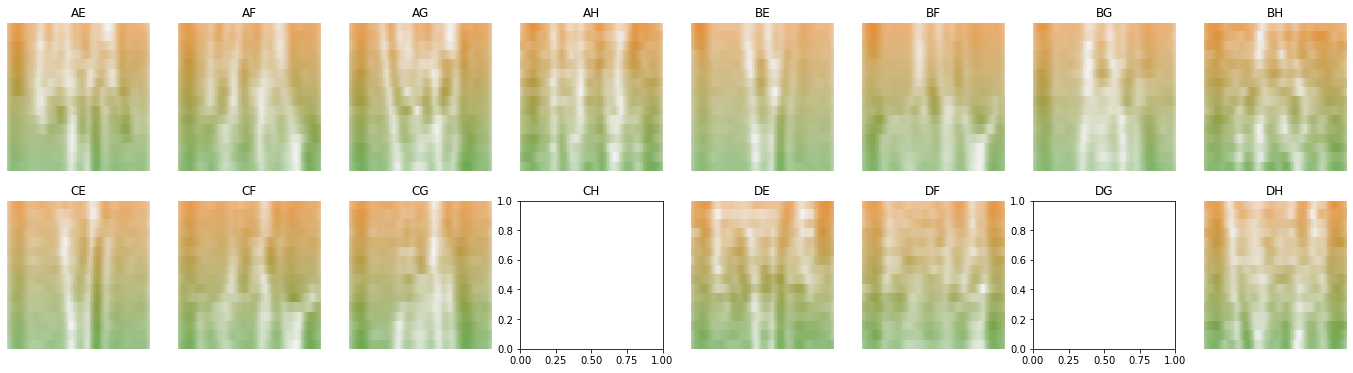

12143


  0%|          | 0/16 [00:00<?, ?it/s]

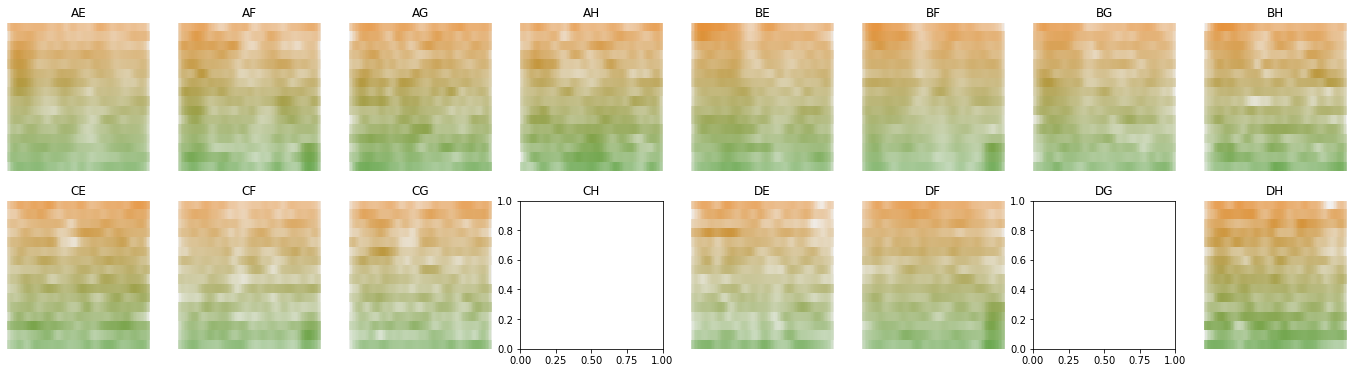

12465


  0%|          | 0/16 [00:00<?, ?it/s]

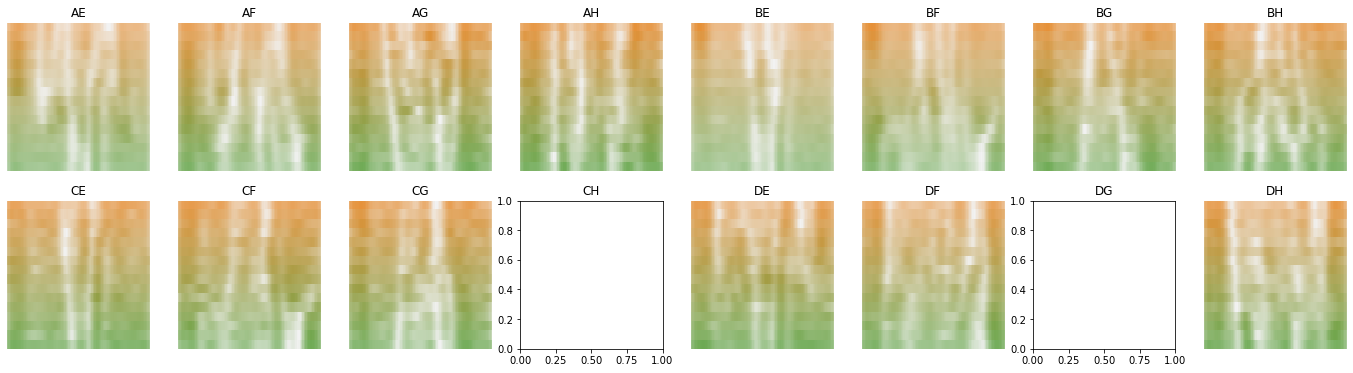

5596


  0%|          | 0/16 [00:00<?, ?it/s]

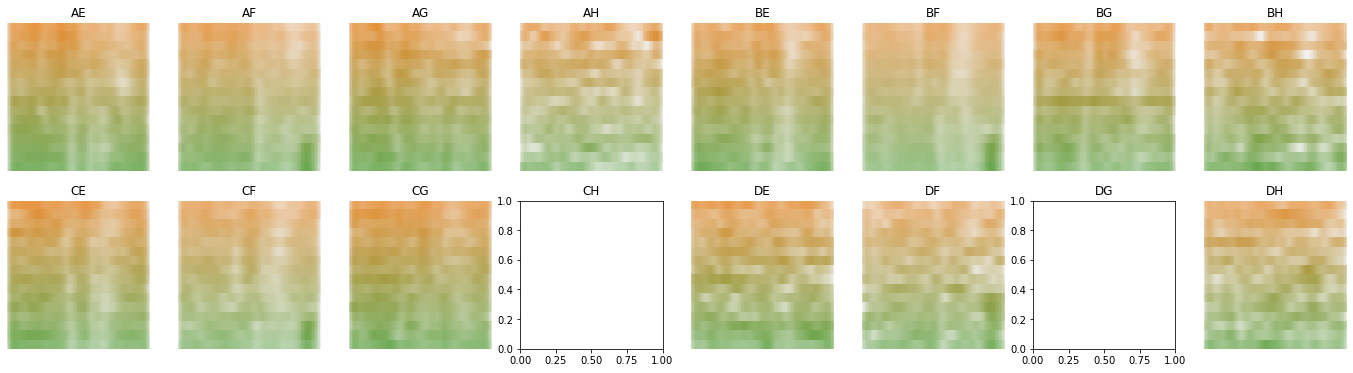

13097


  0%|          | 0/16 [00:00<?, ?it/s]

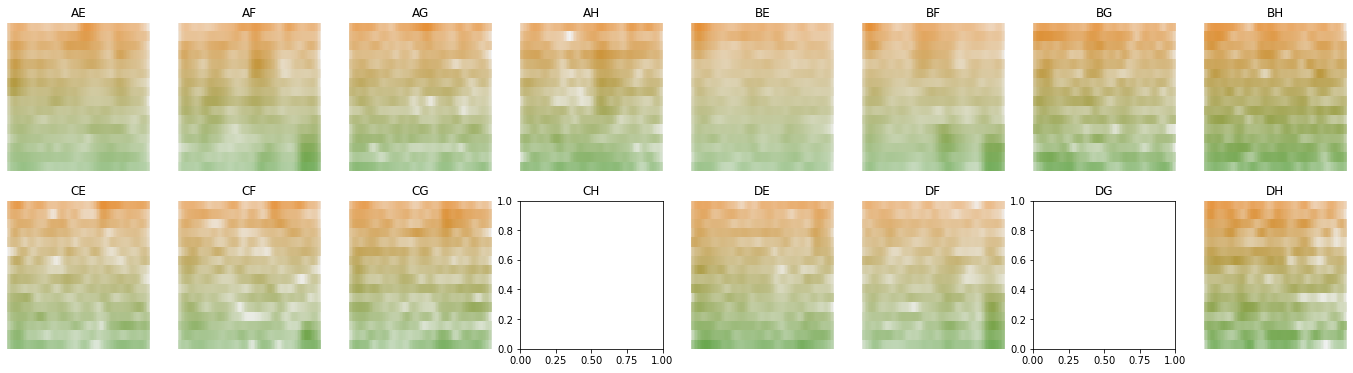

1292


  0%|          | 0/16 [00:00<?, ?it/s]

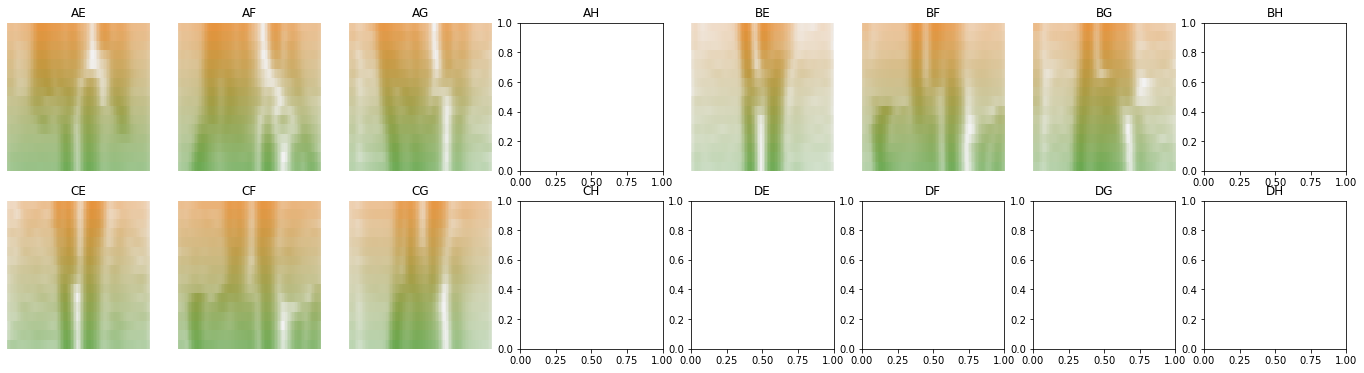

3566


  0%|          | 0/16 [00:00<?, ?it/s]

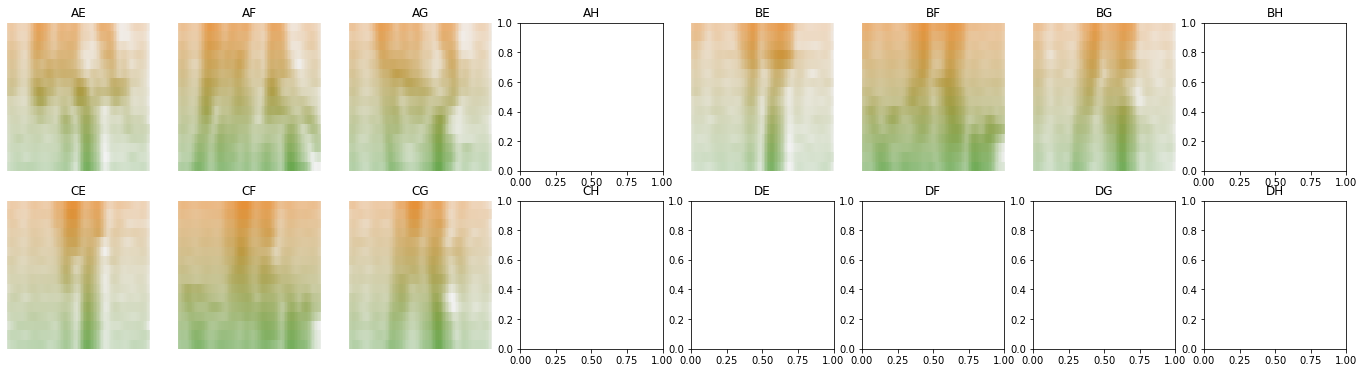

In [38]:
for unit in unit_statistics_df.sort_values(by='n_cued_trials', ascending=False).unit.values[:10]:
    print(unit)
    row = unit_statistics_df[unit_statistics_df.unit == unit].iloc[0]
    fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(24,6))
    for ii, interpolation in enumerate(tqdm(interpolations)):
        ax = axs.flatten()[ii]
        ax.set_title(interpolation)
        metric = "cosine"
        mean_response = np.log(row["rv_{}".format(interpolation)]+1e-5)
        if type(mean_response) is not np.ndarray:
            continue
        ax.imshow(get_cmap(mean_response), interpolation='None', aspect="auto", )
        ax.axis('off')
    plt.show()

### Plot spiketrains

In [39]:
row = unit_statistics_df[unit_statistics_df.unit == "1292"].iloc[0]

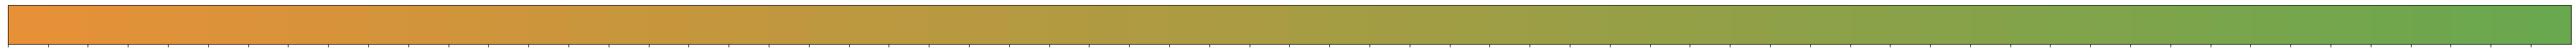

In [40]:
import seaborn as sns
import matplotlib
from cdcp.visualization.colors import colors as cdcp_colors
n_interp_bins_viz = 64
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [cdcp_colors["reinforce"]["L"]["dark"], cdcp_colors["reinforce"]["R"]["dark"]]
)
pal = [cmap(i) for i in np.linspace(0, 1, n_interp_bins_viz)]
sns.palplot(pal)

In [41]:
unit_to_plot = int(row.unit)
bird = row.bird

In [42]:
sorter = birds_df.loc[bird].sorter
unit = int(unit_to_plot)
sort_units = bird_stats[bird]["merged_units"].loc[int(unit_to_plot)].sort_units
spikesorting_folder = bird_stats[bird]["spikesorting_folder"]

In [43]:
from cdcp.spiketrain_analysis.spiketrain_utils import get_unit_spike_trains, bin_interp_points

In [44]:
# spike info
trial_aligned_spikes = get_unit_spike_trains(
    sort_units,
    spikesorting_folder,
    sorter,
    unit,
)

unit spike trains:   0%|          | 0/13 [00:00<?, ?it/s]

In [45]:
# ensure interp point is an integer
trial_aligned_spikes["interp_point_binned"] = bin_interp_points(
    trial_aligned_spikes["interp_point"].astype(int),
    n_interp_bins_viz,
    flip_bins=True,
)

In [46]:
#trial_aligned_spikes = trial_aligned_spikes[trial_aligned_spikes.passive==False]

  0%|          | 0/9 [00:00<?, ?it/s]

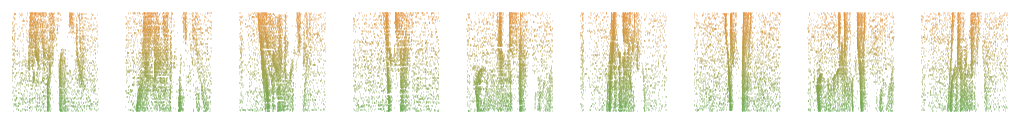

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(18 * 1, 2 * 1))
for ii, interpolation in enumerate(
    tqdm(["AE", "AF", "AG", "BE", "BF", "BG", "CE", "CF", "CG"])
):
    ax = axs[ii]
    interp_trial_aligned_spikes = trial_aligned_spikes[
        (trial_aligned_spikes.interp == interpolation)
    ]
    # ax.set_title(interpolation)
    # get counts
    pts, cts = np.unique(
        interp_trial_aligned_spikes.interp_point_binned, return_counts=True
    )
    n_spikes_per_bin = np.min([5, np.min(cts)])

    for ip in np.sort(interp_trial_aligned_spikes.interp_point_binned.unique()):
        spike_times = interp_trial_aligned_spikes[
            interp_trial_aligned_spikes.interp_point_binned == ip
        ].spike_times.values
        spike_cues = interp_trial_aligned_spikes[
            interp_trial_aligned_spikes.interp_point_binned == ip
        ].cue.values
        if len(spike_times) < n_spikes_per_bin:
            continue
            # raise ValueError
        samps = np.random.choice(len(spike_times), n_spikes_per_bin, replace=False)
        for i, samp in enumerate(samps):
            color = pal[ip]
            if spike_cues[samp] == "NC":
                sts = spike_times[samp][spike_times[samp] < 1]
            else:
                sts = spike_times[samp][spike_times[samp] > 1] - 1
            ax.vlines(
                sts,
                lw=0.5,
                ymin=(-ip * n_spikes_per_bin + i),
                ymax=(-ip * n_spikes_per_bin) + i + 1,
                color=color,
                rasterized=True,
            )
    ax.axis("off")
    #break

ensure_dir(FIGURE_DIR / "neural_results" / "neurometric_vs_psychometric")
if save_figs:
    save_fig(
        FIGURE_DIR
        / "neural_results"
        / "neurometric_vs_psychometric"
        / "sample_unit_spiketrains_25",
        save_pdf=True,
        save_png=True,
    )
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

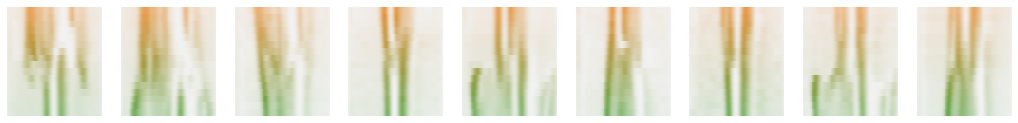

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(18,2))
for ii, interpolation in enumerate(tqdm(['AE', 'AF', 'AG', 'BE', 'BF', 'BG', 'CE', 'CF', 'CG'])):
    ax = axs.flatten()[ii]
    #ax.set_title(interpolation)
    metric = "cosine"
    mean_response = row["rv_{}".format(interpolation)]
    if type(mean_response) is not np.ndarray:
        continue
    ax.imshow(get_cmap(mean_response), interpolation='None', aspect="auto",)
    ax.axis('off')
    
if save_figs:
    save_fig(
        FIGURE_DIR
        / "neural_results"
        / "neurometric_vs_psychometric"
        / "sample_unit_spikevectors_25",
        save_pdf=True,
        save_png=True,
    )
    
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

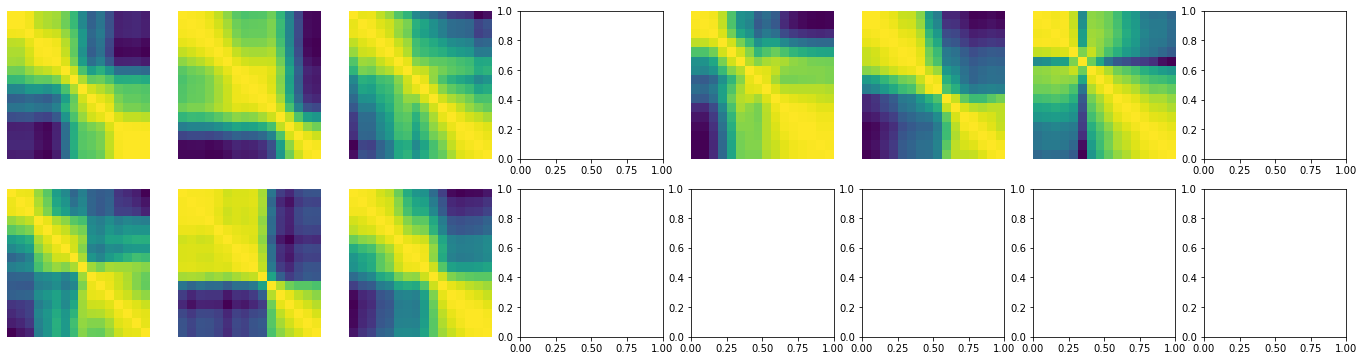

In [49]:
fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(24,6))
for ii, interpolation in enumerate(tqdm(interpolations)):
    ax = axs.flatten()[ii]
    #ax.set_title(interpolation)
    metric = "cosine"
    sm = row["sm_{}_{}".format(metric, interpolation)]
    if type(sm) is not np.ndarray:
        continue
    ax.matshow(sm, interpolation='None', aspect="auto", cmap = 'viridis')
    ax.axis('off')
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

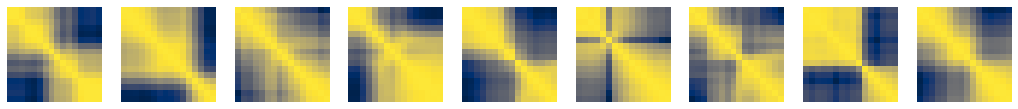

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(18,2))
for ii, interpolation in enumerate(tqdm(['AE', 'AF', 'AG', 'BE', 'BF', 'BG', 'CE', 'CF', 'CG'])):
    ax = axs.flatten()[ii]
    #ax.set_title(interpolation)
    metric = "cosine"
    sm = row["sm_{}_{}".format(metric, interpolation)]
    if type(sm) is not np.ndarray:
        continue
    ax.matshow(sm, interpolation='None',  cmap = 'cividis')
    ax.axis('off')
    
if save_figs:
    save_fig(
        FIGURE_DIR
        / "neural_results"
        / "neurometric_vs_psychometric"
        / "sample_unit_similarity_matrices_25",
        save_pdf=True,
        save_png=True,
    )
    
    
plt.show()

In [51]:
from matplotlib.colors import LinearSegmentedColormap
def get_cmap_matrix(sm, left_to_right_colors=["#e69138", "#6aa84f"]):
    n_samp = len(sm)
    hs = int(n_samp/2)
    assert n_samp % 2 == 0
    
    categorical_gradient_cmap = LinearSegmentedColormap.from_list(
        "left_to_right", left_to_right_colors, N=3
    )
    cmaps = {}
    for gpi, grad_point in enumerate(
        categorical_gradient_cmap(np.linspace(0, 1, 3))
    ):
        cmaps[gpi] = LinearSegmentedColormap.from_list(
            "test", [(1, 1, 1, 1), grad_point], N=512
        )
    A = cmaps[0](sm[:hs, :hs])
    C = cmaps[1](sm[hs:, :hs])
    B = cmaps[1](sm[:hs, hs:])
    D = cmaps[2](sm[hs:, hs:])
        
    mapped = np.vstack([np.hstack([A,B]), np.hstack([C,D])])
    return mapped

  0%|          | 0/4 [00:00<?, ?it/s]

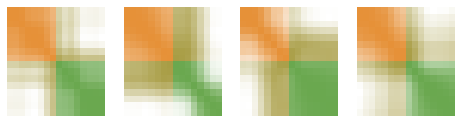

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(8,2))
for ii, interpolation in enumerate(tqdm(['AE', 'AF', 'BE', 'CG'])):
    ax = axs.flatten()[ii]
    #ax.set_title(interpolation)
    metric = "cosine"
    sm = row["sm_{}_{}".format(metric, interpolation)]
    if type(sm) is not np.ndarray:
        continue
    ax.imshow(get_cmap_matrix(zero_one_norm(sm)), interpolation='None', aspect="auto", cmap = 'bone')
    ax.axis('off')
plt.show()

In [53]:
from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic

from cdcp.spiketrain_analysis.neurometric import (
    get_interp_points_dists_from_similarity_matrix,
)

In [54]:
interp_range = np.linspace(0,16, 1000)
n_interp_point_bins = 16

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.collections as mcoll
import matplotlib.path as mpath

def colorline(
    x, y,  z=None,ax=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)
    if ax is None:
        ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


In [56]:
left_to_right_colors=["#F17D00", "#e69138", "#6aa84f", "#5EB707"]
categorical_gradient_cmap = LinearSegmentedColormap.from_list(
    "left_to_right", left_to_right_colors, N=128
)

  0%|          | 0/9 [00:00<?, ?it/s]

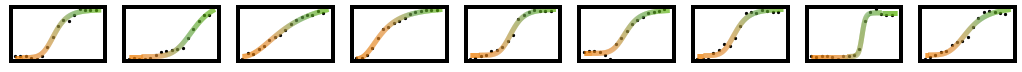

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(18,1))
for ii, interpolation in enumerate(tqdm(['AE', 'AF', 'AG', 'BE', 'BF', 'BG', 'CE', 'CF', 'CG'])):
    ax = axs.flatten()[ii]
    #ax.set_title(interpolation)
    metric = "cosine"
    sm = row["sm_{}_{}".format(metric, interpolation)]
    if type(sm) is not np.ndarray:
        continue
    _slope = row["nm_slope_{}_{}".format(metric, interpolation)]
    _inflection = row["nm_inflection_{}_{}".format(metric, interpolation)]
    _min = row["nm_min_{}_{}".format(metric, interpolation)]
    _max = row["nm_max_{}_{}".format(metric, interpolation)]
    y = FourParameterLogistic(
        {
            "_min": _min,
            "_max": _max,
            "inflection": _inflection,
            "slope": _slope,
        },
        interp_range,
    )
    interp_points, dists = get_interp_points_dists_from_similarity_matrix(
        np.arange(n_interp_point_bins), sm, n_interp_point_bins=n_interp_point_bins
    )
    interp_points = np.array(interp_points)[np.isnan(dists) == False]
    dists = np.array(dists)[np.isnan(dists) == False]
    
    
    colorline(interp_range, y, ax = ax, cmap=categorical_gradient_cmap, linewidth=5)
    #ax.plot(interp_range, y, lw=3, color = 'k')
    #ax.axis('off')
    ax.scatter(interp_points, dists, color = 'k', s = 5)
    ax.set_yticks([])
    ax.set_xticks([])
    [i.set_linewidth(4) for i in ax.spines.values()]
if save_figs:
    save_fig(
        FIGURE_DIR
        / "neural_results"
        / "neurometric_vs_psychometric"
        / "sample_unit_neurometric_25",
        save_pdf=True,
        save_png=True,
    )

In [58]:
"""from matplotlib.colors import LinearSegmentedColormap


def get_cmap(
    interp,
    left_to_right_colors=["#e69138", "#6aa84f"],
    left_to_right_colors_light=["#fce5cd", "#73A64D"],
    left_to_right_colors_dark=["#AA6317", "#426830"],
):
    n_samp = len(interp)

    categorical_gradient_cmap = LinearSegmentedColormap.from_list(
        "left_to_right", left_to_right_colors, N=n_samp
    )
    categorical_gradient_cmap_light = LinearSegmentedColormap.from_list(
        "left_to_right_colors_light", left_to_right_colors_light, N=n_samp
    )
    categorical_gradient_cmap_dark = LinearSegmentedColormap.from_list(
        "categorical_gradient_cmap_dark", left_to_right_colors_dark, N=n_samp
    )
    cmaps = {}
    for gpi, (grad_point_light, grad_point, grad_point_dark) in enumerate(
        zip(
            categorical_gradient_cmap(np.linspace(0, 1, n_samp)),
            categorical_gradient_cmap_light(np.linspace(0, 1, n_samp)),
            categorical_gradient_cmap_dark(np.linspace(0, 1, n_samp)),
        )
    ):
        cmaps[gpi] = LinearSegmentedColormap.from_list(
            "test", 
            [(0.95, 0.95, 0.95, 1), grad_point_light, grad_point], 
            #[(0.1, 0.1, 0.1, 1), grad_point_dark, grad_point, grad_point_light], 
            N=512
        )
    mapped = np.stack([cmaps[i](j) for i, j in enumerate(zero_one_norm(interp))])
    return mapped"""

'from matplotlib.colors import LinearSegmentedColormap\n\n\ndef get_cmap(\n    interp,\n    left_to_right_colors=["#e69138", "#6aa84f"],\n    left_to_right_colors_light=["#fce5cd", "#73A64D"],\n    left_to_right_colors_dark=["#AA6317", "#426830"],\n):\n    n_samp = len(interp)\n\n    categorical_gradient_cmap = LinearSegmentedColormap.from_list(\n        "left_to_right", left_to_right_colors, N=n_samp\n    )\n    categorical_gradient_cmap_light = LinearSegmentedColormap.from_list(\n        "left_to_right_colors_light", left_to_right_colors_light, N=n_samp\n    )\n    categorical_gradient_cmap_dark = LinearSegmentedColormap.from_list(\n        "categorical_gradient_cmap_dark", left_to_right_colors_dark, N=n_samp\n    )\n    cmaps = {}\n    for gpi, (grad_point_light, grad_point, grad_point_dark) in enumerate(\n        zip(\n            categorical_gradient_cmap(np.linspace(0, 1, n_samp)),\n            categorical_gradient_cmap_light(np.linspace(0, 1, n_samp)),\n            categorical_g

In [59]:
from matplotlib.colors import LinearSegmentedColormap
def get_cmap(interp, left_to_right_colors=["#e69138", "#6aa84f"]):
    n_samp = len(interp)

    categorical_gradient_cmap = LinearSegmentedColormap.from_list(
        "left_to_right", left_to_right_colors, N=n_samp
    )
    cmaps = {}
    for gpi, grad_point in enumerate(
        categorical_gradient_cmap(np.linspace(0, 1, n_samp))
    ):
        cmaps[gpi] = LinearSegmentedColormap.from_list(
            "test", [(0.95, 0.95, 0.95, 1), grad_point], N=512
        )
    mapped = np.stack([cmaps[i](j) for i, j in enumerate(zero_one_norm(interp))])
    return mapped

sm_manhattan:   0%|          | 0/10828 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

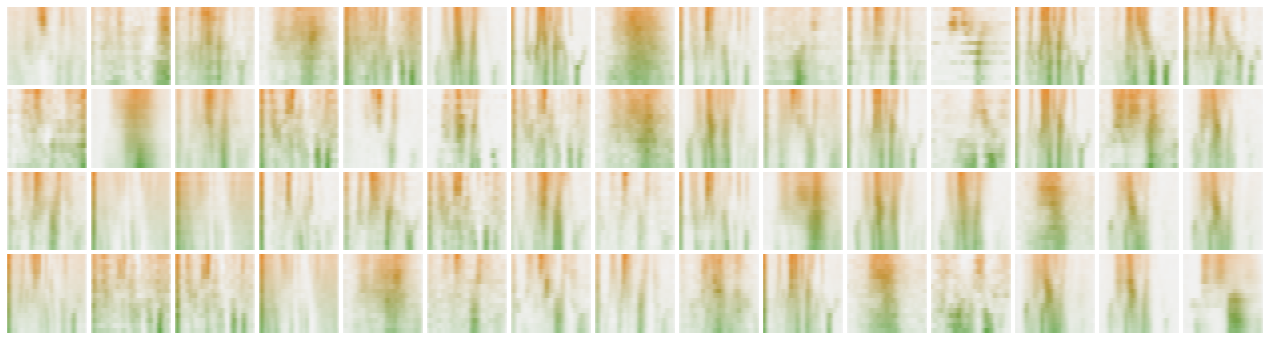

In [60]:
sort_param = "categoricality"
sorted_unit_statistics_df = pd.concat([unit_statistics_df_non_cat, unit_statistics_df]).sort_values(by=sort_param)
sorted_unit_statistics_df[sorted_unit_statistics_df.rv_ALL.isnull() == False]
sorted_unit_statistics_df = sorted_unit_statistics_df[sorted_unit_statistics_df.n_trials > 2500]
prop_nan = np.array(
    [
        np.mean(np.isnan(i)) if type(i) == np.ndarray else 1
        for i in tqdm(sorted_unit_statistics_df['rv_ALL'].values, leave=False, desc=interped_column)
    ]
)
sorted_unit_statistics_df['prop_nan'] = prop_nan
sorted_unit_statistics_df = sorted_unit_statistics_df[sorted_unit_statistics_df.prop_nan == 0]

nrows = 4
ncols = 15
zoom = 1.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * zoom, nrows * zoom),
    gridspec_kw={"wspace": 0.05, "hspace": 0.05},
)
for i, ix in enumerate(tqdm(np.linspace(10000, len(sorted_unit_statistics_df)-1, nrows*ncols).astype(int))):
    row = sorted_unit_statistics_df.iloc[ix]
    rv = row.rv_ALL
    rv = rv / np.max(rv)
    ax = axs.T.flatten()[i]
    ax.imshow(get_cmap(rv), interpolation='None', aspect="auto", )   
    ax.axis("off")

sm_manhattan:   0%|          | 0/10828 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

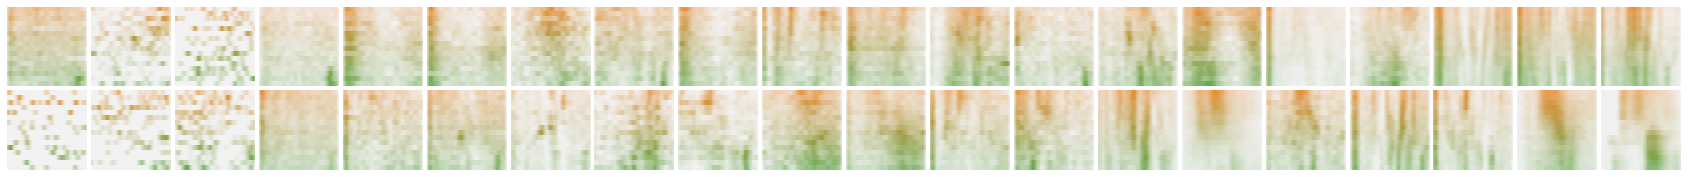

In [61]:
sort_param = "categoricality"
sorted_unit_statistics_df = pd.concat([unit_statistics_df_non_cat, unit_statistics_df]).sort_values(by=sort_param)
sorted_unit_statistics_df[sorted_unit_statistics_df.rv_ALL.isnull() == False]
sorted_unit_statistics_df = sorted_unit_statistics_df[sorted_unit_statistics_df.n_trials > 2500]
prop_nan = np.array(
    [
        np.mean(np.isnan(i)) if type(i) == np.ndarray else 1
        for i in tqdm(sorted_unit_statistics_df['rv_ALL'].values, leave=False, desc=interped_column)
    ]
)
sorted_unit_statistics_df['prop_nan'] = prop_nan
sorted_unit_statistics_df = sorted_unit_statistics_df[sorted_unit_statistics_df.prop_nan == 0]

nrows = 2
ncols = 20
zoom = 1.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * zoom, nrows * zoom),
    gridspec_kw={"wspace": 0.05, "hspace": 0.05},
)
for i, ix in enumerate(tqdm(np.linspace(3500, len(sorted_unit_statistics_df)-1, nrows*ncols).astype(int))):
    row = sorted_unit_statistics_df.iloc[ix]
    rv = row.rv_ALL
    rv = rv / np.max(rv)
    ax = axs.T.flatten()[i]
    ax.imshow(get_cmap(zero_one_norm(rv)), interpolation='None', aspect="auto", )   
    ax.axis("off")
    
if True:
    save_fig(
        FIGURE_DIR
        / "neural_results"
        / "neurometric_vs_psychometric"
        / "categoricality-strip-vectors",
        save_pdf=True,
        save_png=True,
    )

In [62]:
len(sorted_unit_statistics_df)

10828

In [63]:
ix

10827

sm_manhattan:   0%|          | 0/10828 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

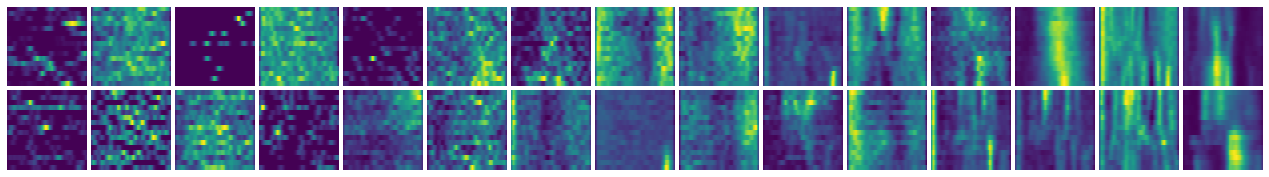

In [64]:
sort_param = "categoricality"
sorted_unit_statistics_df = pd.concat([unit_statistics_df_non_cat, unit_statistics_df]).sort_values(by=sort_param)
sorted_unit_statistics_df[sorted_unit_statistics_df.rv_ALL.isnull() == False]
sorted_unit_statistics_df = sorted_unit_statistics_df[sorted_unit_statistics_df.n_trials > 2500]
prop_nan = np.array(
    [
        np.mean(np.isnan(i)) if type(i) == np.ndarray else 1
        for i in tqdm(sorted_unit_statistics_df['rv_ALL'].values, leave=False, desc=interped_column)
    ]
)
sorted_unit_statistics_df['prop_nan'] = prop_nan
sorted_unit_statistics_df = sorted_unit_statistics_df[sorted_unit_statistics_df.prop_nan == 0]

nrows = 2
ncols = 15
zoom = 1.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * zoom, nrows * zoom),
    gridspec_kw={"wspace": 0.05, "hspace": 0.05},
)
for i, ix in enumerate(tqdm(np.linspace(0, len(sorted_unit_statistics_df)-1, nrows*ncols).astype(int))):
    row = sorted_unit_statistics_df.iloc[ix]
    rv = row.rv_ALL
    rv = rv / np.max(rv)
    ax = axs.T.flatten()[i]
    #ax.imshow(get_cmap(rv), interpolation='None', aspect="auto", )   
    ax.matshow(rv, interpolation='None', aspect="auto", cmap = 'viridis')   
    ax.axis("off")

sm_manhattan:   0%|          | 0/10828 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

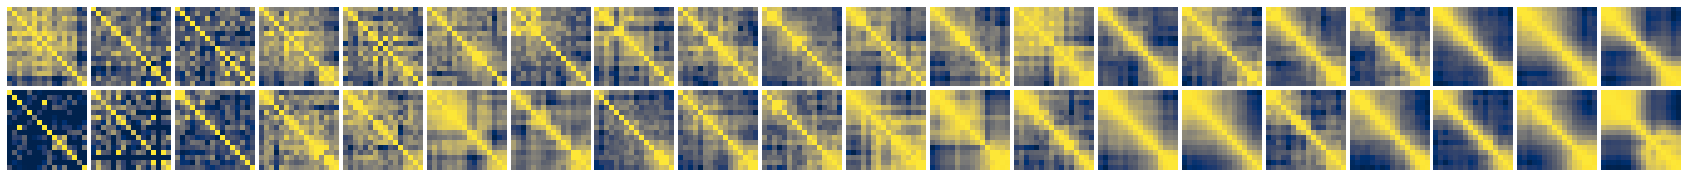

In [65]:
sort_param = "categoricality"
sorted_unit_statistics_df = pd.concat([unit_statistics_df_non_cat, unit_statistics_df]).sort_values(by=sort_param)
sorted_unit_statistics_df[sorted_unit_statistics_df.rv_ALL.isnull() == False]
sorted_unit_statistics_df = sorted_unit_statistics_df[sorted_unit_statistics_df.n_trials > 2500]
prop_nan = np.array(
    [
        np.mean(np.isnan(i)) if type(i) == np.ndarray else 1
        for i in tqdm(sorted_unit_statistics_df['rv_ALL'].values, leave=False, desc=interped_column)
    ]
)
sorted_unit_statistics_df['prop_nan'] = prop_nan
sorted_unit_statistics_df = sorted_unit_statistics_df[sorted_unit_statistics_df.prop_nan == 0]

nrows = 2
ncols = 20
zoom = 1.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * zoom, nrows * zoom),
    gridspec_kw={"wspace": 0.05, "hspace": 0.05},
)
for i, ix in enumerate(tqdm(np.linspace(3500, len(sorted_unit_statistics_df)-1, nrows*ncols).astype(int))):
    row = sorted_unit_statistics_df.iloc[ix]
    rv = row["sm_{}_ALL".format(metric)]
    rv = rv / np.max(rv)
    ax = axs.T.flatten()[i]
    ax.matshow(rv, interpolation='None', aspect="auto", vmax = np.nanmax(np.tril(rv, k=-1)), cmap = plt.cm.cividis) 
    ax.axis("off")
    
if True:
    save_fig(
        FIGURE_DIR
        / "neural_results"
        / "neurometric_vs_psychometric"
        / "categoricality-strip-similarity-matrices",
        save_pdf=True,
        save_png=True,
    )

### Averages across interpolations

In [66]:
def ismat(x):
    if type(x) == np.ndarray:
        if np.shape(x) == (16,16):
            return True
    return False

In [67]:
len(interpolations)

16

  0%|          | 0/9 [00:00<?, ?it/s]

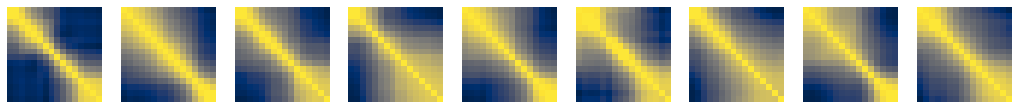

In [68]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(18,2))
for ii, interpolation in enumerate(tqdm(['AE', "AF", 'AG', "BE", "BF", "BG", "CE", "CF", "CG"])):
    ax = axs.flatten()[ii]
    #ax.set_title(interpolation)
    metric = "cosine"
    mean_response = np.nanmean(
        np.stack(
            [
                zero_one_norm(row["sm_{}".format(metric)])
                for idx, row in stat_df[stat_df.interp == interpolation].iterrows()
                if ismat(row["sm_{}".format(metric)])
            ]
        ),
        axis=0,
    )
    ax.matshow(mean_response, vmax = np.max(np.tril(mean_response, k=-1)), interpolation='None', cmap = 'cividis')
    ax.axis('off')

if save_figs:
    save_fig(
        FIGURE_DIR
        / "neural_results"
        / "neurometric_vs_psychometric"
        / "mean_similarity_25",
        save_pdf=True,
        save_png=True,
    )
    
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

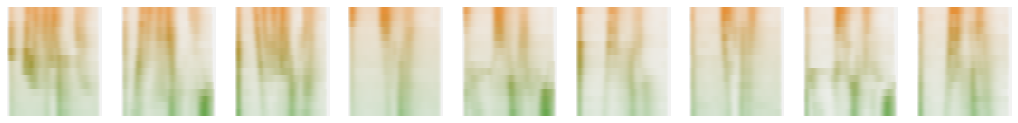

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(18,2))
for ii, interpolation in enumerate(tqdm(['AE', "AF", 'AG', "BE", "BF", "BG", "CE", "CF", "CG"])):
    ax = axs.flatten()[ii]
    #ax.set_title(interpolation, fontsize=24, fontweight='bold')
    metric = "cosine"
    mean_response = np.nanmean(
        np.stack(
            [
                zero_one_norm(row["rv"])
                for idx, row in stat_df[stat_df.interp == interpolation].iterrows()
                if type(row["rv"]) == np.ndarray
            ]
        ),
        axis=0,
    )
    ax.imshow(get_cmap(zero_one_norm(np.clip(mean_response, 0.15, 0.4))), interpolation='None', aspect="auto", )   
    ax.axis('off')

if True:
    save_fig(
        FIGURE_DIR
        / "neural_results"
        / "neurometric_vs_psychometric"
        / "mean_response",
        save_pdf=True,
        save_png=True,
    )    
plt.show()

In [70]:
np.min(mean_response)

0.08646398

In [71]:
np.max(mean_response)

0.36140972

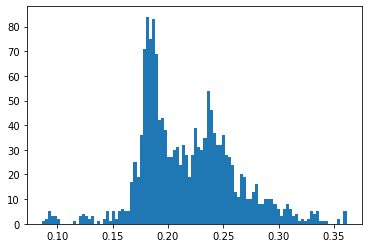

In [72]:
plt.hist(mean_response.flatten(), bins=100);

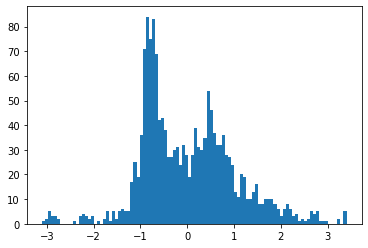

In [73]:
plt.hist(z_score(mean_response).flatten(), bins=100);